   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

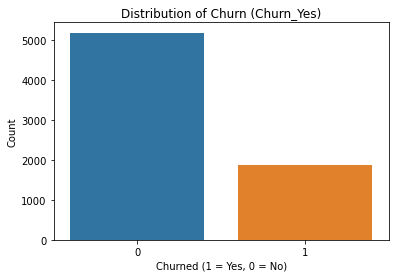

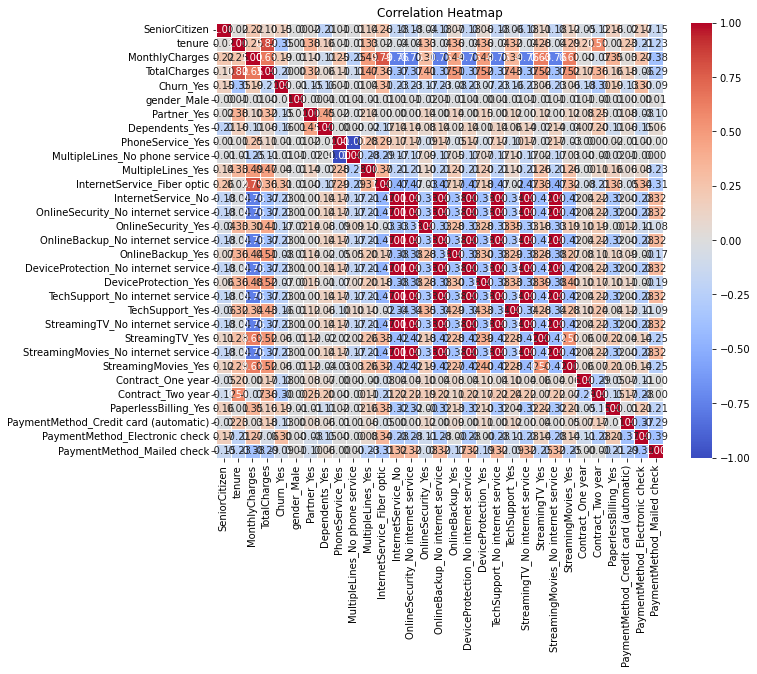

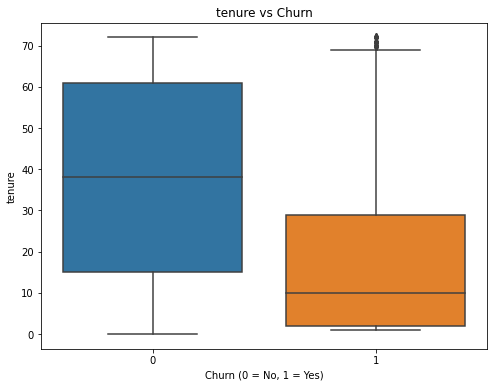

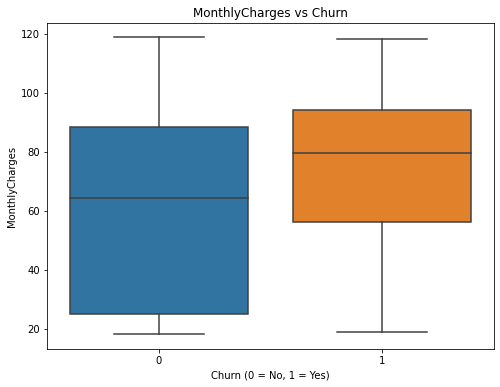

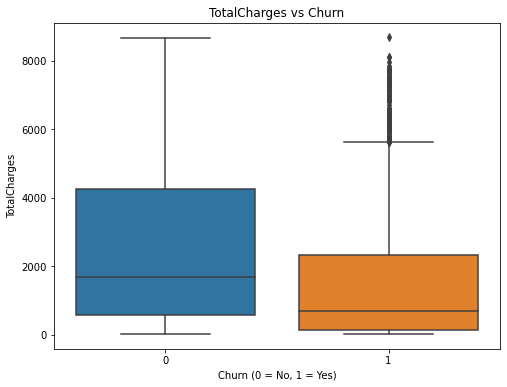

Churn Class Distribution:
 0    5174
1    1869
Name: Churn_Yes, dtype: int64


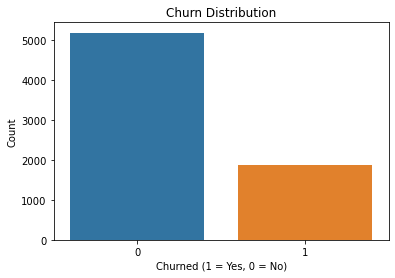

In [2]:
# Load Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Load the Dataset
df = pd.read_csv('C:/Users/nhif/Downloads/Customer Churn Prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Display First Few Rows
print(df.head())

# Check Dataset Structure
print(f"Shape of dataset: {df.shape}")
print(df.info())

# Check for Missing Values
print("Missing Values:\n", df.isnull().sum())

# -------------------------------
# Data Preprocessing
# -------------------------------

# Handle Missing Values in 'TotalCharges'
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')  # Convert to numeric, replacing blanks with NaN
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)  # Fill missing values with mean

# Convert 'Churn' Column to Numeric Target Variable
df['Churn_Yes'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Drop Unnecessary Columns (Customer ID is irrelevant)
df.drop(columns=['customerID', 'Churn'], inplace=True)

# Handle Missing Categorical Values
df.fillna(df.mode().iloc[0], inplace=True)

# Ensure 'SeniorCitizen' is Integer
df['SeniorCitizen'] = df['SeniorCitizen'].astype(int)

# Convert Categorical Variables to Strings Before Encoding
categorical_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'Contract', 'PaperlessBilling', 'PaymentMethod']
for col in categorical_columns:
    if col in df.columns:  # Ensure column exists
        df[col] = df[col].astype(str)

# One-Hot Encoding for Categorical Features
df = pd.get_dummies(df, drop_first=True)

# -------------------------------
# Feature Scaling
# -------------------------------

# Separate Features and Target Variable
X = df.drop(columns=['Churn_Yes'])  
y = df['Churn_Yes']  

# Standardize Numeric Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert Scaled Features Back to DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# -------------------------------
# Exploratory Data Analysis (EDA)
# -------------------------------

# 1. Churn Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title('Distribution of Churn (Churn_Yes)')
plt.xlabel('Churned (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

# 2. Correlation Heatmap for Numeric Features
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# 3. Categorical Features vs. Churn
categorical_columns = [col for col in categorical_columns if col in df.columns]  # Ensure columns exist

for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=col, hue=y, data=df)
    plt.title(f'{col} vs Churn')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# 4. Numeric Features vs. Churn
numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
for col in numeric_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=y, y=col, data=df)
    plt.title(f'{col} vs Churn')
    plt.xlabel('Churn (0 = No, 1 = Yes)')
    plt.ylabel(col)
    plt.show()

# 5. Check for Class Imbalance
print("Churn Class Distribution:\n", y.value_counts())
sns.countplot(x=y)
plt.title('Churn Distribution')
plt.xlabel('Churned (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()


### Train-Test Split
#### After preprocessing, you should split the data into training and test sets for model evaluation.

In [3]:
from sklearn.model_selection import train_test_split

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


### Model Building

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Logistic Regression Model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on Test Set
y_pred = model.predict(X_test)

# Evaluate Model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}')
print(f'Classification Report:\n {classification_report(y_test, y_pred)}')


Accuracy: 0.8204400283889283
Confusion Matrix:
 [[934 102]
 [151 222]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.69      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.81      0.82      0.82      1409



### Cross-Validation 
##### This ensures that your model is not overfitting to a specific train-test split.

In [5]:
from sklearn.model_selection import cross_val_score

# Cross-validation score
cv_scores = cross_val_score(model, X_scaled, y, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {cv_scores.mean()}')


Cross-Validation Scores: [0.80340667 0.81192335 0.7920511  0.81036932 0.80397727]
Mean CV Score: 0.8043455424543519


# Feature Importance 
##### You can examine feature importance to understand which features are most predictive of churn.

In [6]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Feature Importance
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importance)


TotalCharges                             0.203803
MonthlyCharges                           0.170567
tenure                                   0.163268
InternetService_Fiber optic              0.034857
PaymentMethod_Electronic check           0.034845
Contract_Two year                        0.032340
gender_Male                              0.028820
OnlineSecurity_Yes                       0.026351
PaperlessBilling_Yes                     0.026032
Partner_Yes                              0.023674
TechSupport_Yes                          0.022877
Contract_One year                        0.022441
OnlineBackup_Yes                         0.021166
MultipleLines_Yes                        0.020267
Dependents_Yes                           0.019925
SeniorCitizen                            0.019888
DeviceProtection_Yes                     0.018996
StreamingMovies_Yes                      0.018357
StreamingTV_Yes                          0.016836
PaymentMethod_Credit card (automatic)    0.013827
